In [1]:
import rebound
import reboundx
from celmech import Andoyer
import numpy as np
import sys
import time
%matplotlib inline
import matplotlib.pyplot as plt

try:
    plt.style.use('paper')
except:
    print("style not found")

In [2]:
def makesim(): #jk = None returns single planet
    avars = Andoyer.from_Z(j=3, k=1, Z=0.032, phi=np.pi, Zstar=0.032, m1=1.e-3, m2=1.e-3)
    return avars.to_Simulation()

In [3]:
np.exp(4)**1.5

403.4287934927351

In [4]:
1/1e4*400

0.04

In [5]:
def warmup(Pf, dtfactor, tmax, taue, K, rebxintegrator):
    simSP = makesim()
    ps = simSP.particles
    simSP.integrator="none"
    simSP.dt = dtfactor*ps[1].P
    rebxSP = reboundx.Extras(simSP)
    keplerSP = rebxSP.load_operator("kepler")
    interSP = rebxSP.load_operator("interaction")
    psSP = simSP.particles
    P0 = psSP[1].P

    if taue:
        integforceSP = rebxSP.load_operator("integrate_force")
        modSP = rebxSP.load_force("modify_orbits_forces")
        integforceSP.params['force'] = modSP
        integforceSP.params['integrator'] = reboundx.integrators[rebxintegrator]

        for p in psSP[1:]:
            p.params['tau_e'] = -taue*Pf
        psSP[2].params['tau_a'] = -taue*Pf*K

        rebxSP.add_operator(keplerSP, dt_fraction=0.5, timing="post")
        rebxSP.add_operator(interSP, dt_fraction=0.5, timing="post")
        rebxSP.add_operator(integforceSP, dt_fraction=1., timing="post")
        rebxSP.add_operator(interSP, dt_fraction=0.5, timing="post")
        rebxSP.add_operator(keplerSP, dt_fraction=0.5, timing="post")
    else:
        rebxSP.add_operator(keplerSP, dt_fraction=0.5, timing="post")
        rebxSP.add_operator(interSP, dt_fraction=1., timing="post")
        rebxSP.add_operator(keplerSP, dt_fraction=0.5, timing="post")

    sim = makesim()
    sim.integrator="ias15"
    ps = sim.particles

    if taue:
        rebx = reboundx.Extras(sim)
        mod = rebx.load_force("modify_orbits_forces")
        rebx.add_force(mod)

        for p in ps[1:]:
            p.params['tau_e'] = -taue*Pf
        ps[2].params['tau_a'] = -taue*Pf*K

    simSP.integrate(tmax, exact_finish_time=0) # Integrate to let dissipation take you to resonance center
    sim.integrate(simSP.steps_done*simSP.dt)

    simSP.steps_done = 0
    simSP.t = 0
    sim.t = 0
    return sim, simSP, rebx, rebxSP

# Iterate to get a Pf for tau_a and tau_e such that we actually get the same final P at the end as we put in at the beginning

In [6]:
%%time
tmax=1.e5
taue = 1.e3
K = 100
dtfactor=0.01 # After a goes down by factor of 100, P by 1000, still at 10% orb period
rebxintegrator = 'rk4'

Pf = 2*np.pi # initial guess
for i in range(4):
    sim, simSP, rebx, rebxSP = warmup(Pf, dtfactor, tmax, taue, K, rebxintegrator)
    Pf = sim.particles[1].P
    print(i, Pf)

KeyboardInterrupt: 

In [10]:
def resdamping(filename, dtfactor, tmax, taue, K, rebxintegrator):
    Pf = 5.331391854550496 # hardcoded from above so that the period at the end of the warmup is correct
    sim, simSP, rebx, rebxSP = warmup(Pf, dtfactor, 1.e1, taue, K, rebxintegrator)
    
    Nout = 1000
    tmax = 1.e4

    psSP = simSP.particles
    ps = sim.particles
    P0 = ps[1].P

    times = np.linspace(0, tmax*P0, Nout)
    sim.simulationarchive_snapshot(filename+"IAS.sa")
    simSP.simulationarchive_snapshot(filename+".sa")
    rebx.save(filename+'IAS.rebx')
    rebxSP.save(filename+'.rebx')

    Nout = 3
    times = np.linspace(0, tmax*P0, Nout)

    for i, time in enumerate(times):
        simSP.integrate(time, exact_finish_time=0)
        sim.integrate(simSP.steps_done*simSP.dt)
        sim.simulationarchive_snapshot(filename+"IAS.sa")
        simSP.simulationarchive_snapshot(filename+".sa")

In [11]:
%%time

tmax=1.e1
taue = 1.e3
K = 100
dtfactor=1.e-2 # After a goes down by factor of 100, P by 1000, still at 10% orb period
rebxintegrator = 'rk4'
filename = 'binaries/damprk4'
resdamping(filename, dtfactor, tmax, taue, K, rebxintegrator)

CPU times: user 12.1 s, sys: 0 ns, total: 12.1 s
Wall time: 12.1 s


In [12]:
filename = 'binaries/damprk4'
sa = reboundx.SimulationArchive(filename+'.sa', rebxfilename = filename+".rebx")

In [13]:
sim, rebx = sa[-1]
sim.t

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


RuntimeError: REBOUNDx: Binary file is unreadable. Please open an issue on Github mentioning the version of REBOUND and REBOUNDx you are using and include the binary file.

In [48]:
%%time
times, E, e, Pratio = {}, {}, {}, {}

rebxintegrators = ['rk4']

for rebxintegrator in rebxintegrators:
    filename = 'binaries/damp'+rebxintegrator
    print(filename)
    saSP = reboundx.SimulationArchive(filename+'.sa', rebxfilename = filename+".rebx")
    sa = reboundx.SimulationArchive(filename+'IAS.sa', rebxfilename = filename+"IAS.rebx")
    sim, rebx = sa[0]
    P = sim.particles[1].P
    
    times[rebxintegrator], times[rebxintegrator+'IAS'] = np.zeros(sa.nblobs), np.zeros(sa.nblobs)
    E[rebxintegrator], E[rebxintegrator+'IAS'] = np.zeros(sa.nblobs), np.zeros(sa.nblobs)
    e[rebxintegrator], e[rebxintegrator+'IAS'] = np.zeros(sa.nblobs), np.zeros(sa.nblobs)
    Pratio[rebxintegrator], Pratio[rebxintegrator+'IAS'] = np.zeros(sa.nblobs), np.zeros(sa.nblobs)
    for i, (sim, rebx) in enumerate(sa):
        times[rebxintegrator+'IAS'][i] = sim.t/P
        E[rebxintegrator+'IAS'][i] = sim.calculate_energy()
        e[rebxintegrator+'IAS'][i] = sim.particles[1].e
        Pratio[rebxintegrator+'IAS'][i] = sim.particles[2].P/sim.particles[1].P
        
    for i, (sim, rebx) in enumerate(saSP):
        times[rebxintegrator][i] = sim.t/P
        E[rebxintegrator][i] = sim.calculate_energy()
        e[rebxintegrator][i] = sim.particles[1].e
        Pratio[rebxintegrator][i] = sim.particles[2].P/sim.particles[1].P

binaries/damprk4


RuntimeError: REBOUNDx: Binary file is unreadable. Please open an issue on Github mentioning the version of REBOUND and REBOUNDx you are using and include the binary file.

In [43]:
%%time
Nout = 1000
tmax = 1.e4

psSP = simSP.particles
ps = sim.particles
P0 = ps[1].P

times = np.linspace(0, tmax*P0, Nout)
ksSP, t, eSP, ESP, PratioSP = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
ks, e, E, Pratio = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)

for i, time in enumerate(times):
    simSP.integrate(time, exact_finish_time=0)
    sim.integrate(simSP.steps_done*simSP.dt)
    t[i] = simSP.t/P0
    
    ksSP[i] = psSP[1].e*np.cos(psSP[1].pomega)
    eSP[i] = psSP[1].e
    ESP[i] = simSP.calculate_energy()
    PratioSP[i] = psSP[2].P/psSP[1].P
    
    ks[i] = ps[1].e*np.cos(ps[1].pomega)
    e[i] = ps[1].e
    E[i] = sim.calculate_energy()
    Pratio[i] = ps[2].P/ps[1].P

KeyboardInterrupt: 

In [16]:
simSP.dt/sim.particles[1].P

0.012590690888159055

In [17]:
simSP.particles[1].P

4.975322466029062

In [34]:
times

{'rk4': array([0.]), 'rk4IAS': array([0.])}

No handles with labels found to put in legend.


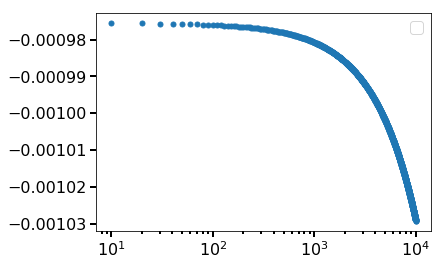

In [45]:
fig, ax = plt.subplots()

ax.plot(times['rk4IAS'], E['rk4IAS'], '.')
#ax.plot(t/2/np.pi, EWH, label='WH')
#ax.plot(t/2/np.pi, EWH, label='Split')
#ax.set_yscale('log')
ax.set_xscale('log')
#ax.plot(t/2/np.pi, [0]*len(t))
#ax.set_xlabel('Time (orbits)')
#ax.set_ylabel(r'$\Delta \varpi_{err}$cv')
#ax.set_title(r'Absolute $\varpi err$')
ax.legend()

In [47]:
E['rk4']

array([0., 0., 0., ..., 0., 0., 0.])

No handles with labels found to put in legend.


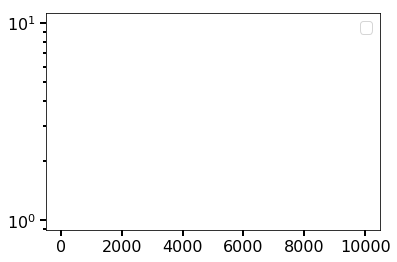

In [46]:
fig, ax = plt.subplots()
#plt.rcParams["text.usetex"] =True
#plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

ax.plot(times['rk4IAS'], (E['rk4']-E['rk4IAS'])/E['rk4IAS'], '.')
#ax.plot(t/2/np.pi, EWH, label='WH')
#ax.plot(t/2/np.pi, EWH, label='Split')
ax.set_yscale('log')
#ax.set_xscale('log')
#ax.plot(t/2/np.pi, [0]*len(t))
#ax.set_xlabel('Time (orbits)')
#ax.set_ylabel(r'$\Delta \varpi_{err}$cv')
#ax.set_title(r'Absolute $\varpi err$')
ax.legend()

No handles with labels found to put in legend.


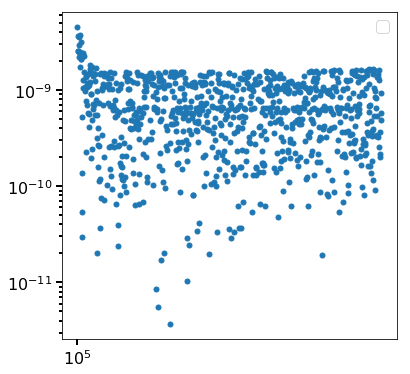

In [176]:
fig, ax = plt.subplots()
#plt.rcParams["text.usetex"] =True
#plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

ax.plot(t, (ESP-E)/E, '.')
#ax.plot(t/2/np.pi, EWH, label='WH')
#ax.plot(t/2/np.pi, EWH, label='Split')
ax.set_yscale('log')
ax.set_xscale('log')
#ax.plot(t/2/np.pi, [0]*len(t))
#ax.set_xlabel('Time (orbits)')
#ax.set_ylabel(r'$\Delta \varpi_{err}$cv')
#ax.set_title(r'Absolute $\varpi err$')
ax.legend()

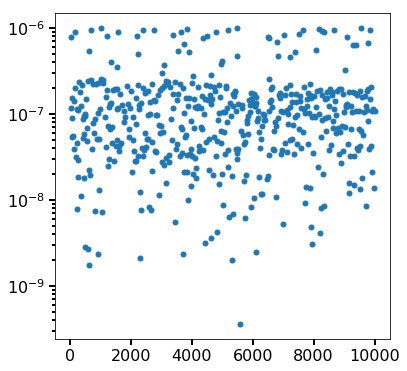

In [223]:
fig, ax = plt.subplots()
#plt.rcParams["text.usetex"] =True
#plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

ax.plot(t, e-eSP, '.')
ax.set_yscale('log')
#ax.set_xscale('log')

#ax.plot(t/2/np.pi, eWH)
#ax.plot(t/2/np.pi, [0]*len(t))
#ax.set_xlabel('Time (orbits)')
#ax.set_ylabel(r'$\Delta \varpi_{err}$cv')
#ax.set_title(r'Absolute $\varpi err$')

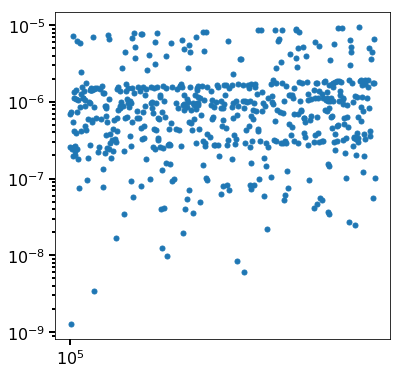

In [166]:
fig, ax = plt.subplots()
#plt.rcParams["text.usetex"] =True
#plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

ax.plot(t, e-eSP, '.')
ax.set_yscale('log')
ax.set_xscale('log')

#ax.plot(t/2/np.pi, eWH)
#ax.plot(t/2/np.pi, [0]*len(t))
#ax.set_xlabel('Time (orbits)')
#ax.set_ylabel(r'$\Delta \varpi_{err}$cv')
#ax.set_title(r'Absolute $\varpi err$')

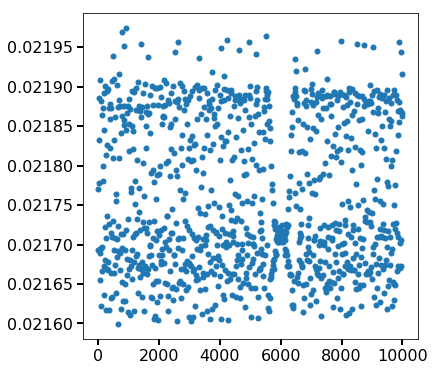

In [225]:
fig, ax = plt.subplots()
#plt.rcParams["text.usetex"] =True
#plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

ax.plot(t, e, '.')
#ax.set_yscale('log')
#ax.set_xscale('log')

#ax.plot(t/2/np.pi, eWH)
#ax.plot(t/2/np.pi, [0]*len(t))
#ax.set_xlabel('Time (orbits)')
#ax.set_ylabel(r'$\Delta \varpi_{err}$cv')
#ax.set_title(r'Absolute $\varpi err$')

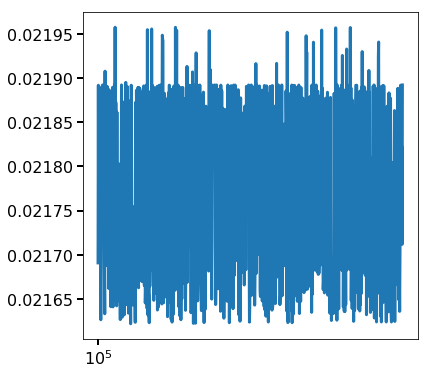

In [168]:
fig, ax = plt.subplots()
#plt.rcParams["text.usetex"] =True
#plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

ax.plot(t, e)
#ax.set_yscale('log')
ax.set_xscale('log')

#ax.plot(t/2/np.pi, eWH)
#ax.plot(t/2/np.pi, [0]*len(t))
#ax.set_xlabel('Time (orbits)')
#ax.set_ylabel(r'$\Delta \varpi_{err}$cv')
#ax.set_title(r'Absolute $\varpi err$')

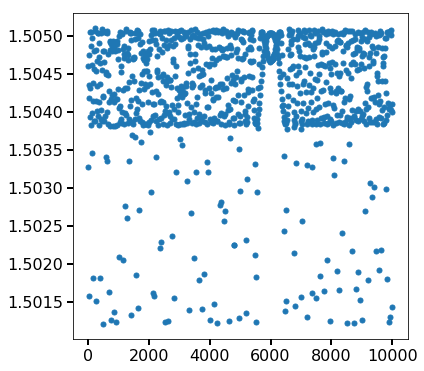

In [226]:
fig, ax = plt.subplots()
#plt.rcParams["text.usetex"] =True
#plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

ax.plot(t, Pratio, '.')
#ax.set_yscale('log')
#ax.set_xscale('log')

#ax.plot(t/2/np.pi, eWH)
#ax.plot(t/2/np.pi, [0]*len(t))
#ax.set_xlabel('Time (orbits)')
#ax.set_ylabel(r'$\Delta \varpi_{err}$cv')
#ax.set_title(r'Absolute $\varpi err$')

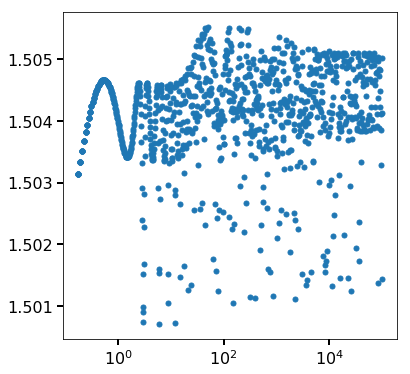

In [99]:
fig, ax = plt.subplots()
#plt.rcParams["text.usetex"] =True
#plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

ax.plot(t, Pratio, '.')
#ax.set_yscale('log')
ax.set_xscale('log')

#ax.plot(t/2/np.pi, eWH)
#ax.plot(t/2/np.pi, [0]*len(t))
#ax.set_xlabel('Time (orbits)')
#ax.set_ylabel(r'$\Delta \varpi_{err}$cv')
#ax.set_title(r'Absolute $\varpi err$')

In [ ]:
%%time
t, ks, ksWH, times = run(tmax=1.e7, jk=None, taue=1.e4, rebxintegrator='rk4')

In [ ]:
try:
    plt.style.use('paper')
except:
    print("style not found")

fig, ax = plt.subplots()
plt.rcParams["text.usetex"] =True
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

ax.plot(t/2/np.pi, ks-ksWH)
ax.plot(t/2/np.pi, [0]*len(t))
ax.set_xlabel('Time (orbits)')
ax.set_ylabel(r'$\Delta \varpi_{err}$cv')
ax.set_title(r'Absolute $\varpi err$')

Text(0.5, 1.0, 'Absolute $\\varpi err$')

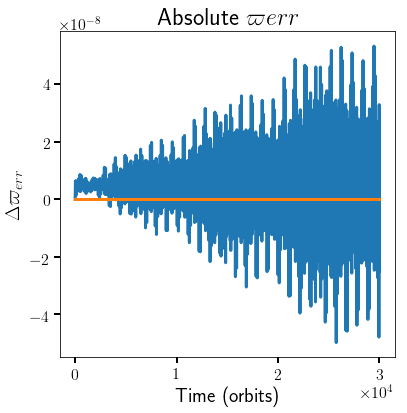

In [56]:
try:
    plt.style.use('paper')
except:
    print("style not found")

fig, ax = plt.subplots()
plt.rcParams["text.usetex"] =True
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

ax.plot(t/2/np.pi, ks-ksWH)
ax.plot(t/2/np.pi, [0]*len(t))
ax.set_xlabel('Time (orbits)')
ax.set_ylabel(r'$\Delta \varpi_{err}$cv')
ax.set_title(r'Absolute $\varpi err$')

Text(0.5, 1.0, 'Absolute $\\varpi err$')

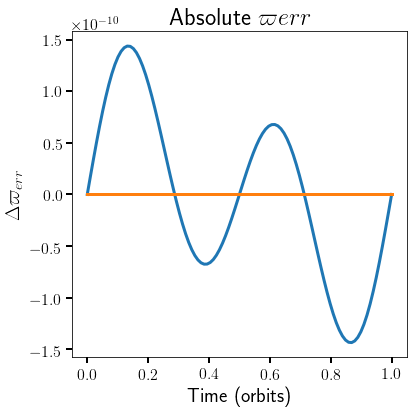

In [21]:
try:
    plt.style.use('paper')
except:
    print("style not found")

fig, ax = plt.subplots()
plt.rcParams["text.usetex"] =True
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

ax.plot(t/2/np.pi, ks-ksWH)
ax.plot(t/2/np.pi, [0]*len(t))
ax.set_xlabel('Time (orbits)')
ax.set_ylabel(r'$\Delta \varpi_{err}$')
ax.set_title(r'Absolute $\varpi err$')

In [7]:
(ks-ksWH)[-1]

1.7082998210460332e-11

In [6]:
def makesim(jk=(3,1)): #jk = None returns single planet
    if jk:
        avars = Andoyer.from_elements(j=jk[0], k=jk[1], Zstar=0.1, libfac=0.2, m1=1.e-4, m2=1.e-4)
        sim = avars.to_Simulation()
    else:
        sim = rebound.Simulation()
        sim.add(m=1.)
        sim.add(m=1.e-4, a=1., e=0.01)
        sim.add(m=1.e-4, a=3., e=0.01)
        sim.move_to_com()
    return sim
    
def run(tmax, jk=(3,1), taue=1.e4, WHFast=True, rebxintegrator="", dtfactor=0.01):   
    sim = makesim(jk)
    ps = sim.particles
    
    if WHFast:
        sim.integrator="whfast"
        sim.dt = dtfactor*ps[1].P
    
        
    if taue:
        rebx = reboundx.Extras(sim)
        mod = rebx.load_force("modify_orbits_forces")
        for p in ps[1:]:
            p.params['tau_e'] = -taue*ps[1].P
        ps[1].params['tau_a'] = taue*ps[1].P*100

        if WHFast:
            integforce = rebx.load_operator("integrate_force")
            rebx.add_operator(integforce, dt_fraction=1., timing="post")
            integforce.params['force'] = mod
            integforce.params['integrator'] = reboundx.integrators[rebxintegrator]
        else:
            rebx.add_force(mod)

        for p in ps[1:]:
            p.params['tau_e'] = -taue*ps[1].P
        ps[1].params['tau_a'] = taue*ps[1].P*100
    
    
    P0 = sim.particles[1].P
    print(P0)
    #sim.integrate(25*taue*P0, exact_finish_time=0)
    print(sim.particles[1].P)
    Nout = 1000
    times = np.linspace(sim.t, sim.t+tmax*P0, Nout)
    ks, t, e, E, Pratio = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    
    for i, time in enumerate(times):
        sim.integrate(time, exact_finish_time=0)
        t[i] = sim.t/P0
        ks[i] = ps[1].e*np.cos(ps[1].pomega)
        e[i] = ps[1].e
        E[i] = sim.calculate_energy()
        Pratio[i] = ps[2].P/ps[1].P
       
    return sim, t, ks, e, E, Pratio

In [37]:
%%time
taues = np.logspace(2, 5, 4)

eWHs, es, EWHs, Es = [], [], [], []
for taue in taues:
    simWH, tWH, ksWH, eWH, EWH, PratioWH = run(tmax=taue, taue=taue, WHFast=True, rebxintegrator='rk4')
    sim, t, ks, e, E, Pratio = run(tmax=taue, taue=taue, WHFast=False, rebxintegrator='rk4')
    eWHs.append(eWH)
    EWHs.append(EWH)
    es.append(e)
    Es.append(E)
    
simWH, tWH, ksWH, eWH, EWH, PratioWH = run(tmax=1e5, taue=None, WHFast=True, rebxintegrator='rk4')
sim, t, ks, e, E, Pratio = run(tmax=1e5, taue=None, WHFast=False, rebxintegrator='rk4')
eWHs.append(eWH)
EWHs.append(EWH)
es.append(e)
Es.append(E)

taues = [taue for taue in taues]
taues.append("None")

6.2924582144077075
6.2924582144077075
6.2924582144077075
6.2924582144077075
6.2924582144077075
6.2924582144077075
6.2924582144077075
6.2924582144077075
6.2924582144077075
6.2924582144077075
6.2924582144077075
6.2924582144077075
6.2924582144077075
6.2924582144077075
6.2924582144077075
6.2924582144077075
6.2924582144077075
6.2924582144077075
6.2924582144077075
6.2924582144077075
CPU times: user 2min 24s, sys: 261 ms, total: 2min 24s
Wall time: 2min 25s


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


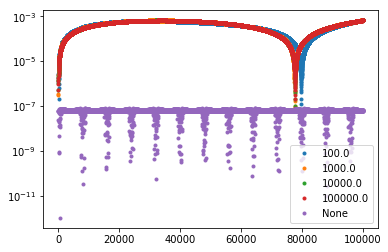

In [38]:
fig, ax = plt.subplots()
for EWH, E, taue in zip(EWHs, Es, taues):
    ax.plot(t, np.abs((EWH-E[0])/E[0]), '.', label=taue)
ax.set_yscale('log')
ax.legend()

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


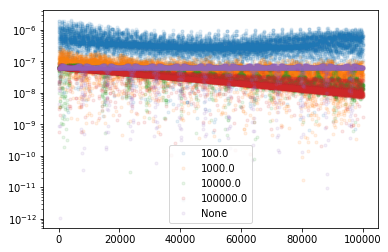

In [47]:
fig, ax = plt.subplots()
for EWH, E, taue in zip(EWHs, Es, taues):
    ax.plot(t, np.abs((EWH-E)/E), '.', alpha=0.1, label=taue)
ax.set_yscale('log')
ax.legend()

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


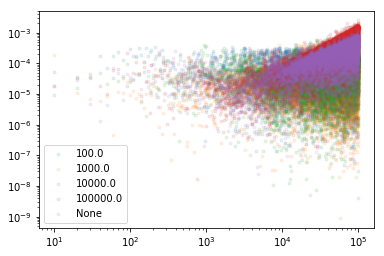

In [62]:
fig, ax = plt.subplots()
for eWH, e, taue in zip(eWHs, es, taues):
    try:
        if taue < 1e6:
            ax.plot(t, np.abs((eWH-e)/e), '.', alpha=0.1, label=taue)
    except:
        ax.plot(t, np.abs((eWH-e)/e), '.', alpha=0.1, label=taue)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


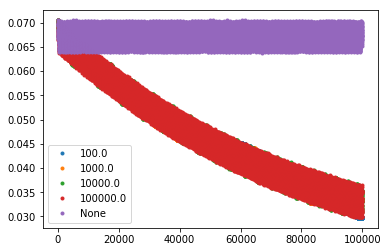

In [61]:
fig, ax = plt.subplots()
for eWH, e, taue in zip(eWHs, es, taues):
    ax.plot(t, eWH, '.', label=taue)
#ax.set_yscale('log')
ax.legend()
#ax.set_xscale('log')
#ax.plot(t, eeuler)
#ax.plot(t, e)

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


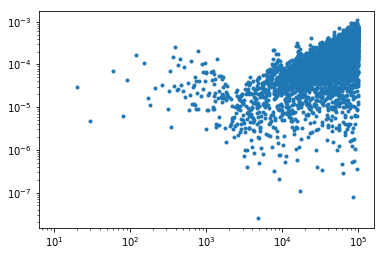

In [58]:
fig, ax = plt.subplots()
ax.plot(t, (eWHs[-1]-es[-1])/es[-1], '.')
ax.set_yscale('log')
ax.set_xscale('log')
#ax.plot(t, eeuler)
#ax.plot(t, e)

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


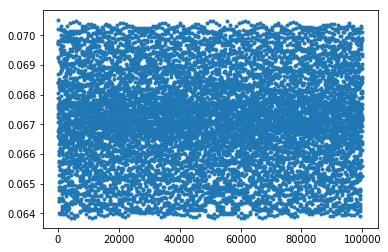

In [64]:
fig, ax = plt.subplots()
ax.plot(t, es[-1], '.')
#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.plot(t, eeuler)
#ax.plot(t, e)

In [66]:
%%time
simWH, tWH, ksWH, eWH, EWH, PratioWH = run(tmax=1e5, dtfactor=0.1, taue=None, WHFast=True, rebxintegrator='rk4')
sim, t, ks, e, E, Pratio = run(tmax=1e5, dtfactor=0.1, taue=None, WHFast=False, rebxintegrator='rk4')


6.2924582144077075
6.2924582144077075
6.2924582144077075
6.2924582144077075
CPU times: user 40.8 s, sys: 37.5 ms, total: 40.8 s
Wall time: 40.8 s


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


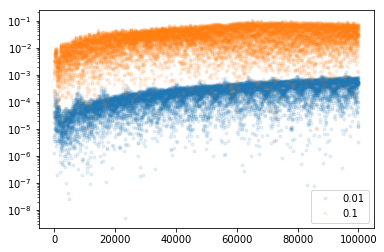

In [68]:
fig, ax = plt.subplots()
ax.plot(t, np.abs((eWHs[-1]-es[-1])/es[-1]), '.', alpha=0.1, label='0.01')
ax.plot(t, np.abs((eWH-e)/e), '.', alpha=0.1, label='0.1')
ax.set_yscale('log')
ax.legend()

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


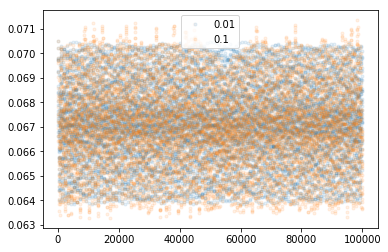

In [70]:
fig, ax = plt.subplots()
ax.plot(t, eWHs[-1], '.', alpha=0.1, label='0.01')
ax.plot(t, eWH, '.', alpha=0.1, label='0.1')
#ax.set_yscale('log')
ax.legend()

In [38]:
%%time
tWH, ksWH, eWH, EWH, PratioWH = run(tmax=1e5, taue=1000, WHFast=True, rebxintegrator='rk4')
teuler, kseuler, eeuler, Eeuler, Pratioeuler = run(tmax=1e5, taue=1000, WHFast=True, rebxintegrator='euler')
t, ks, e, E, Pratio = run(tmax=1e5, taue=1000, WHFast=False, rebxintegrator='rk4')

6.2924582144077075
6.70278303308338
6.2924582144077075
6.702766790648828
6.2924582144077075
6.702539520510011
CPU times: user 1min 11s, sys: 39.5 ms, total: 1min 11s
Wall time: 1min 11s


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


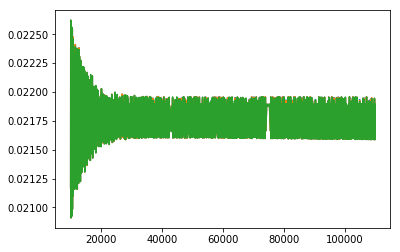

In [44]:
fig, ax = plt.subplots()
ax.plot(t, eWH)
ax.plot(t, eeuler)
ax.plot(t, e)

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


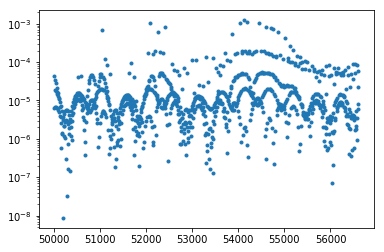

In [27]:
fig, ax = plt.subplots()
ax.plot(t, np.abs((eWH-eeuler)/eWH), '.')
ax.set_yscale('log')

In [77]:
def run(filename, tmax=1.e4, taue=1.e4, WHFast=True, rebxintegrator="", dtfactor=0.01):   
    sim = rebound.Simulation(filename)
    sim.t = 0
    ps = sim.particles
    P0 = 2*np.pi
    
    rebx = reboundx.Extras(sim)
    mod = rebx.load_force("modify_orbits_forces")
    for p in ps[1:]:
        p.params['tau_e'] = -taue*P0
    ps[1].params['tau_a'] = taue*P0*100

    if WHFast:
        sim.integrator="whfast"
        sim.dt = dtfactor*P0
        integforce = rebx.load_operator("integrate_force")
        rebx.add_operator(integforce, dt_fraction=1., timing="post")
        integforce.params['force'] = mod
        integforce.params['integrator'] = reboundx.integrators[rebxintegrator]
    else:
        rebx.add_force(mod)
    
    Nout = 10000
    times = np.linspace(0, tmax*P0, Nout)
    ks, t, e, E, Pratio, P1, Zstar = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    print(P0)
    for i, time in enumerate(times):
        sim.integrate(time, exact_finish_time=0)
        t[i] = sim.t/P0
        ks[i] = ps[1].e*np.cos(ps[1].pomega)
        e[i] = ps[1].e
        E[i] = sim.calculate_energy()
        Pratio[i] = ps[2].P/ps[1].P
        P1[i] = ps[1].P
        avars = Andoyer.from_Simulation(sim, 3, 1)
        Zstar[i] = avars.Zstar
       
    return sim, t, ks, e, E, Pratio, P1, Zstar

In [64]:
%%time
taue=1000
P0 = 2*np.pi
jk=(3,1)
avars = Andoyer.from_elements(j=jk[0], k=jk[1], Zstar=0.1, libfac=0.2, m1=1.e-4, m2=1.e-4)
sim = avars.to_Simulation()
ps = sim.particles
rebx = reboundx.Extras(sim)
mod = rebx.load_force("modify_orbits_forces")
for p in ps[1:]:
    p.params['tau_e'] = -taue*P0
ps[1].params['tau_a'] = taue*P0*100
rebx.add_force(mod)
sim.integrate(25*taue*P0, exact_finish_time=0)

CPU times: user 14 s, sys: 12.3 ms, total: 14 s
Wall time: 14 s


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


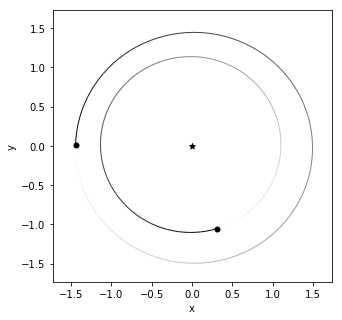

In [60]:
sim.save("res.bin")
fig = rebound.OrbitPlot(sim)

In [ ]:
%%time
simWH, tWH, ksWH, eWH, EWH, PratioWH, P1WH, ZstarWH = run("res.bin", tmax=5e6, taue=1000, WHFast=True, rebxintegrator='rk4')
simeuler, teuler, kseuler, eeuler, Eeuler, Pratioeuler, P1euler, Zstareuler = run("res.bin", tmax=5e6, taue=1000, WHFast=True, rebxintegrator='euler')
sim, t, ks, e, E, Pratio, P1, Zstar = run("res.bin", tmax=5e6, taue=1000, WHFast=False, rebxintegrator='rk4')

/Users/dtamayo/Documents/workspace/rebound/rebound/simulation.py:352: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


6.283185307179586


/Users/dtamayo/Documents/workspace/celmech/celmech/andoyer.py:277: RuntimeWarning: invalid value encountered in double_scalars
  andvars.dKprime = ((j-k)*p['m2']*p['sLambda20']*dL2hat + j*p['m1']*p['sLambda10']*dL1hat)/p['K0']
/Users/dtamayo/Documents/workspace/celmech/celmech/andoyer.py:32: RuntimeWarning: invalid value encountered in double_scalars
  Xstarres = np.sqrt(-Phiprime)*np.sinh(1./3.*np.arcsinh(-abs(Phiprime)**(-1.5)))
/Users/dtamayo/Documents/workspace/celmech/celmech/poincare.py:116: RuntimeWarning: invalid value encountered in sqrt
  sLambda = np.sqrt(sim.G*M*orb.a)
/Users/dtamayo/Documents/workspace/celmech/celmech/poincare.py:117: RuntimeWarning: invalid value encountered in sqrt
  sGamma = sLambda*(1.-np.sqrt(1.-orb.e**2))
/Users/dtamayo/Documents/workspace/celmech/celmech/andoyer.py:201: RuntimeWarning: invalid value encountered in sqrt
  p['sLambda10'] = np.sqrt(G*M1*a10)
/Users/dtamayo/Documents/workspace/celmech/celmech/andoyer.py:202: RuntimeWarning: invalid valu

6.283185307179586
6.283185307179586


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


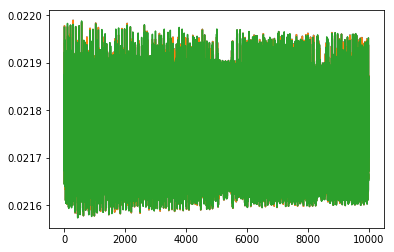

In [79]:
fig, ax = plt.subplots()
ax.plot(t, eWH)
ax.plot(t, eeuler)
ax.plot(t, e)

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


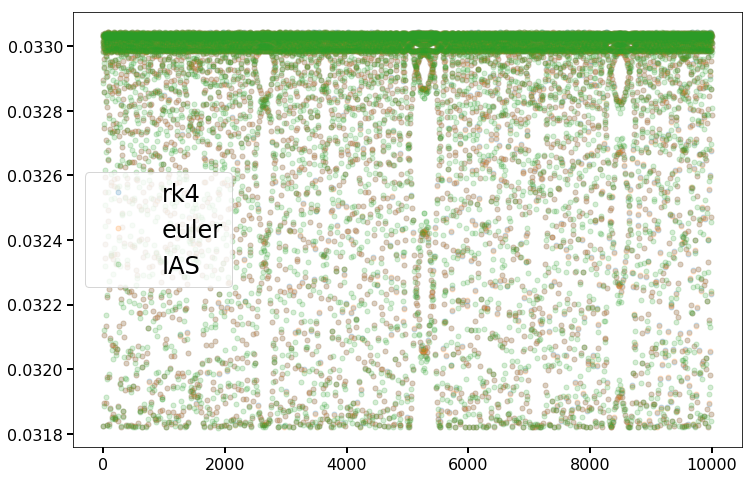

In [88]:
plt.style.use('paper')
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(t, ZstarWH, '.', alpha=0.2, label='rk4')
ax.plot(t, Zstareuler, '.', alpha=0.2, label='euler')
ax.plot(t, Zstar, '.', alpha=0.2, label='IAS')
ax.legend(fontsize=24)

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


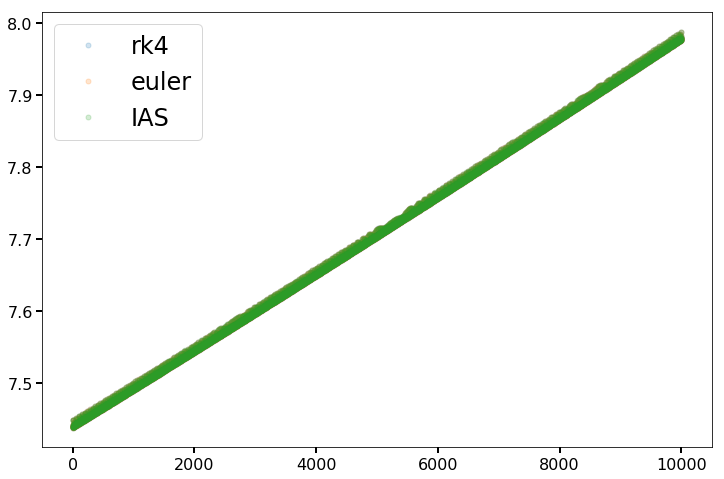

In [89]:
plt.style.use('paper')
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(t, P1WH, '.', alpha=0.2, label='rk4')
ax.plot(t, P1euler, '.', alpha=0.2, label='euler')
ax.plot(t, P1, '.', alpha=0.2, label='IAS')
ax.legend(fontsize=24)

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


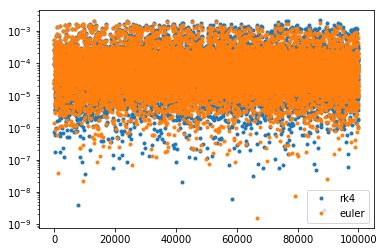

In [72]:
fig, ax = plt.subplots()
ax.plot(t, np.abs((eWH-e)/e), '.', label='rk4')
ax.plot(t, np.abs((eeuler-e)/e), '.', label='euler')
ax.set_yscale('log')
ax.legend()